In [5]:
import pandas as pd
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

### Sample table

In [6]:
dfs = pd.read_excel('./raw/1-s2.0-S0092867417311224-mmc2.xlsx', skiprows=[0,1], index_col=0)
dfs.index.name='samples'
dfs = dfs.rename(columns={'Response':'response', 'Time to Death\n(weeks)':'survival', 'M Stage':'stage', 'Cohort':'cohort'})
dfs['status'] = dfs['Dead/Alive\n(Dead = True)'].map({True:'Dead', False:'Alive'})
dfs['flag'] = dfs.response.map({'PD':0, 'SD':0, 'PR':1, 'CR':1}).to_frame(name='flag')
cols = ['flag', 'response', 'cohort', 'stage', 'status','survival',]
dfs = dfs[cols]
dfs.cohort.value_counts()

cohort
NIV3-PROG     39
NIV3-NAIVE    34
Name: count, dtype: int64

### Mutation table

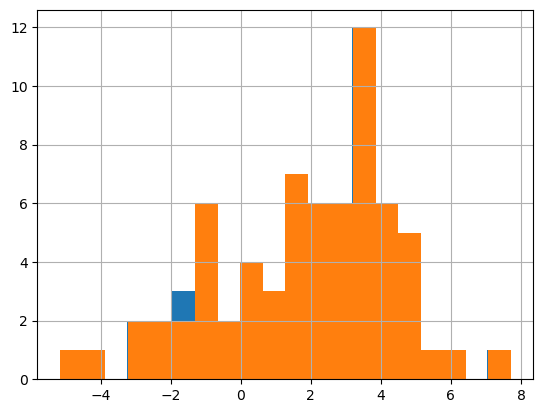

In [7]:
captureSize = 35.8 #for tmb claculation

VC_NONSYNONYMOUS_LIST = [
                         'missense_variant',
                         'stop_gained',
                         'splice_donor_variant&intron_variant ',
                         'splice_acceptor_variant&intron_variant',
                         'stop_lost',
                         'start_lost&splice_region_variant',
                         'missense_variant&splice_region_variant']

truncate_mut_LIST = ['stop_gained', 'splice_acceptor_variant&intron_variant', 'splice_donor_variant&intron_variant ']
nontruncate_mut_LIST = ['missense_variant','stop_lost']

mut = pd.read_excel('./raw/1-s2.0-S0092867417311224-mmc3.xlsx', skiprows=[0,1,2])
mut_series = mut['Variant Classification']

mut['nansynonymous_mut_flag'] = mut_series.isin(VC_NONSYNONYMOUS_LIST)
mut['truncate_mut_flag'] = mut_series.isin(truncate_mut_LIST)
mut['nontruncate_mut_flag'] = mut_series.isin(nontruncate_mut_LIST)

I_calculated_TMB1 = mut.groupby('Patient').nansynonymous_mut_flag.sum()
I_calculated_TMB2 = mut.groupby('Patient').apply(lambda x:x.truncate_mut_flag.sum()*2+x.nontruncate_mut_flag.sum())

#for tmb claculation
tmb1 = np.log2(I_calculated_TMB1/captureSize)
tmb2 = np.log2(I_calculated_TMB2/captureSize)

tmb1.hist(bins=20)
tmb2.hist(bins=20)

tmb = tmb1.to_frame('tmb.dan').join(tmb2.to_frame(name = 'tmb.wang'))

### mRNA table

In [11]:
dfm = pd.read_csv('./raw/GSE91061_BMS038109Sample.hg19KnownGene.fpkm.csv',index_col=0)
dfm = dfm[dfm.columns[dfm.columns.map(lambda x:'_Pre_' in x)]]
dfm.shape

(5100, 51)

In [12]:
df_samples = pd.DataFrame(dfm.columns, columns=['samples'])
df_samples['patient'] = df_samples.samples.map(lambda x:x.split('_')[0])
df_samples = df_samples.set_index('patient').join(dfs)
df_samples = df_samples[~df_samples.flag.isna()]
df_samples = df_samples.join(tmb).reset_index().set_index('samples')

In [13]:
dfm = dfm[df_samples.index]

### convert entrezgene id to gene name

In [14]:
import mygene
mg = mygene.MyGeneInfo()
entrezgene_info = mg.querymany(dfm.index.tolist(), scope='entrezgene', 
                               returnall=True, species= 'human', as_dataframe=True)
entrezgene_id_name_map = entrezgene_info['out'].symbol

INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-5100...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


In [15]:
dfm.index = dfm.index.astype(str)
dfm = dfm.loc[entrezgene_id_name_map.index]
dfm.index = dfm.index.map(entrezgene_id_name_map)

##### fpkm to tpm

In [18]:
def fpkm2tpm(fpkm_matrix):
    '''
    fpkm_matrix: rows: genes, columns: samples/patients
    '''
    _fpkm2tpm = lambda fpkm: np.exp(np.log(fpkm) - np.log(np.sum(fpkm)) + np.log(1e6))
    tpm_matrix = fpkm_matrix.apply(_fpkm2tpm, axis=0)
    return tpm_matrix

In [20]:
df_tpm = fpkm2tpm(dfm)

/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
df_tpm

,Pt1_Pre_AD101148-6,Pt10_Pre_E9047565-6,Pt101_Pre_AD486328-5,Pt103_Pre_AE134058-2,Pt106_Pre_AD502250-5,Pt11_Pre_AD153352-6,Pt17_Pre_E9047563-6,Pt18_Pre_E9024732-6,Pt2_Pre_AD101150-6,Pt24_Pre_AD436687-5,...,Pt8_Pre_AD153354-6,Pt82_Pre_AD823914-8,Pt84_Pre_AD486532-5,Pt85_Pre_AD486329-5,Pt89_Pre_AE070951-5,Pt9_Pre_E9021024-6,Pt90_Pre_AD467873-6,Pt92_Pre_AE134060-5,Pt94_Pre_AD732850-6,Pt98_Pre_AD733586-8
query,,,,,,,,,,,,,,,,,,,,,
A1BG,55.043375,24.394727,36.024350,113.920898,29.629952,14.132544,21.579865,19.383083,11.728944,19.678552,...,39.101272,147.644108,5.039782,74.278769,27.727626,21.688052,47.151933,11.050245,36.713309,36.682377
NAT2,0.000000,0.000000,0.000000,0.000000,0.937238,0.000000,0.000000,0.000000,0.815083,0.000000,...,0.000000,32.832902,1.216593,0.676968,0.000000,3.825906,0.000000,0.000000,0.403808,0.000000
ADA,187.495080,205.363605,553.225798,284.798473,214.855165,147.562751,77.757344,400.573830,310.758288,119.657286,...,143.204315,110.156495,42.182896,87.585363,116.668695,124.615821,236.040829,265.623186,178.775842,73.531157
CDH2,7.615109,24.259060,26.503885,2.098687,285.888502,8.128837,3.929289,443.240369,117.713961,31.483993,...,34.773210,79.753564,24.954977,770.179615,35.478438,620.061365,32.456283,70.817128,18.190846,22.570907
AKT3,472.589411,954.541895,176.013004,74.335266,528.195419,366.453386,98.494094,401.774680,484.528818,131.034759,...,483.790987,441.938575,97.344333,1141.997129,219.407848,593.642754,246.840521,418.181269,358.817381,415.118894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FREM3,0.000000,0.000000,0.000000,0.000000,0.248496,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.434906,0.000000,0.322563,0.000000,0.061756,0.000000,0.200489,0.000000,0.000000,0.000000
MMAA,36.356611,49.103712,46.108232,22.045402,42.577873,78.383518,105.890632,51.992733,36.757549,39.520830,...,52.101791,97.517855,67.940048,72.384468,35.856151,39.000680,51.909983,42.266035,27.203715,59.547400
ZBTB49,41.286478,80.723062,77.208437,11.649512,42.361072,45.659183,34.339221,59.264037,35.380937,31.793072,...,47.794292,44.078423,43.009844,36.353379,23.903960,68.864576,45.720099,55.905689,38.851569,49.651999
